In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Load the data
# Changed file path to the exact one you provided
df = pd.read_csv(r"C:\Users\USER\Documents\Online retail\Online Retail.csv", encoding = "ISO-8859-1")

# Data Cleaning and Preprocessing

# Convert 'InvoiceDate' to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Handle missing values (CustomerID is often used for analysis)
df = df.dropna(subset=['CustomerID'])

# Convert CustomerID to integer (as it's a numerical identifier)
df['CustomerID'] = df['CustomerID'].astype(int)



In [3]:
# Remove rows with negative quantities (returns are handled differently typically)
df = df[df['Quantity'] > 0]

# Calculate total revenue for each transaction
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']



In [4]:
# Descriptive Analytics

print("Basic Data Overview:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nSummary Statistics:")
print(df.describe())



Basic Data Overview:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  year  Month  Day  Hour  UnitPrice  CustomerID  \
0 2010-12-01 08:26:00  2010     12    1     8       2.55       17850   
1 2010-12-01 08:26:00  2010     12    1     8       3.39       17850   
2 2010-12-01 08:26:00  2010     12    1     8       2.75       17850   
3 2010-12-01 08:26:00  2010     12    1     8       3.39       17850   
4 2010-12-01 08:26:00  2010     12    1     8       3.39       17850   

          Country  TotalRevenue  
0  United Kingdom         15.30  
1  United Kingdom         20.34  
2  United K

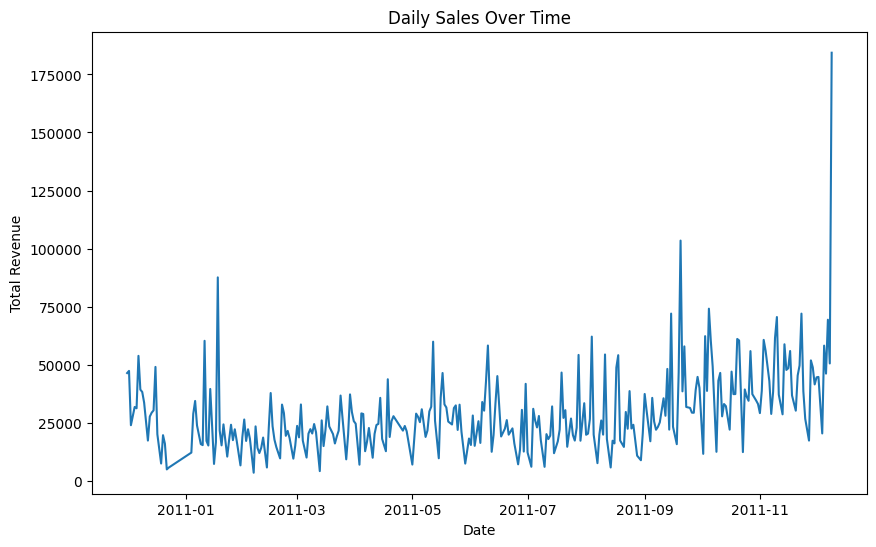

In [5]:
# Time Series Analysis
# Grouping and aggregatting to generate the daily sales trends
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalRevenue'].sum()

# Creating the daily sales plot
plt.figure(figsize=(10,6))
daily_sales.plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.show()




Total Sales by Country:
Country
United Kingdom          7308391.554
Netherlands              285446.340
EIRE                     265545.900
Germany                  228867.140
France                   209024.050
Australia                138521.310
Spain                     61577.110
Switzerland               56443.950
Belgium                   41196.340
Sweden                    38378.330
Japan                     37416.370
Norway                    36165.440
Portugal                  33439.890
Finland                   22546.080
Singapore                 21279.290
Channel Islands           20450.440
Denmark                   18955.340
Italy                     17483.240
Cyprus                    13590.380
Austria                   10198.680
Poland                     7334.650
Israel                     7221.690
Greece                     4760.520
Iceland                    4310.000
Canada                     3666.380
USA                        3580.390
Malta                      2725

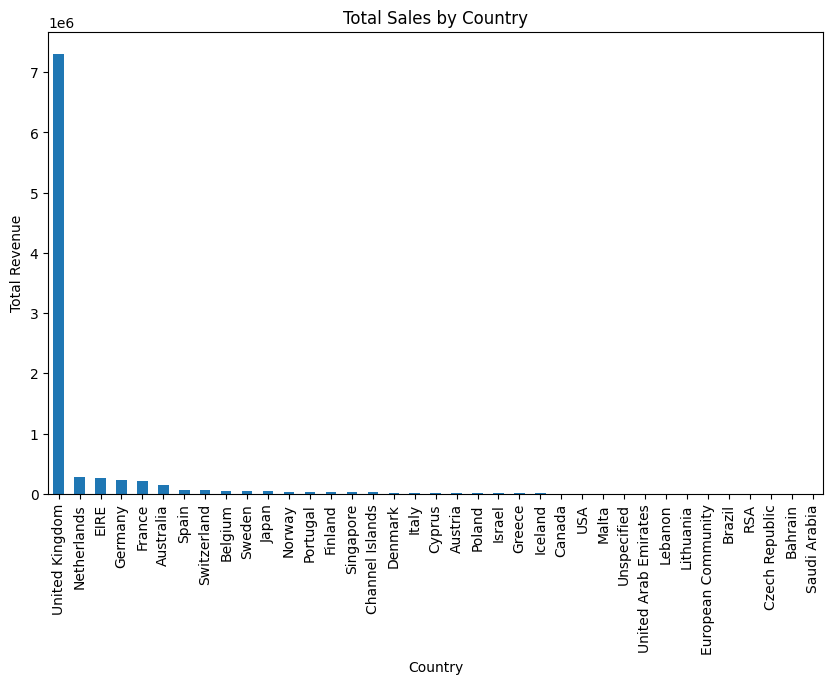

In [6]:
# Country-Based Analysis

country_sales = df.groupby('Country')['TotalRevenue'].sum().sort_values(ascending=False)

print("\nTotal Sales by Country:")
print(country_sales)

plt.figure(figsize=(10,6))
country_sales.plot(kind='bar')
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.show()



In [7]:
# RFM Analysis

# Calculate Recency (days since last purchase)
now = df['InvoiceDate'].max()
rfm_recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
rfm_recency['Recency'] = (now - rfm_recency['InvoiceDate']).dt.days
rfm_recency = rfm_recency[['CustomerID', 'Recency']]

# Calculate Frequency (number of purchases)
rfm_frequency = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
rfm_frequency.columns = ['CustomerID', 'Frequency']

# Calculate Monetary Value (total spending)
rfm_monetary = df.groupby('CustomerID')['TotalRevenue'].sum().reset_index()
rfm_monetary.columns = ['CustomerID', 'MonetaryValue']

# Merge RFM values
rfm = pd.merge(rfm_recency, rfm_frequency, on='CustomerID')
rfm = pd.merge(rfm, rfm_monetary, on='CustomerID')

print("\nRFM Data:")
print(rfm.head())




RFM Data:
   CustomerID  Recency  Frequency  MonetaryValue
0       12346      325          1       77183.60
1       12347        1        182        4310.00
2       12348       74         31        1797.24
3       12349       18         73        1757.55
4       12350      309         17         334.40


In [16]:
# Segmenting using Quantiles (you can adjust the number of quantiles)
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

#Functions to define the rfm levels based on the quantile values
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
# Calculate RFM segments
rfm['R'] = rfm['Recency'].apply(RScoring, args=('Recency', quantiles))
rfm['F'] = rfm['Frequency'].apply(FnMScoring, args=('Frequency', quantiles))
rfm['M'] = rfm['MonetaryValue'].apply(FnMScoring, args=('MonetaryValue', quantiles))

# Combine RFM scores into a single segment value
rfm['RFM_Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['RFM_Score'] = rfm['R'] + rfm['F'] + rfm['M']

print("\nRFM Segments:")
print(rfm.head())



RFM Segments:
   CustomerID  Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  \
0       12346      325          1       77183.60  4  4  1         441   
1       12347        1        182        4310.00  1  1  1         111   
2       12348       74         31        1797.24  3  3  1         331   
3       12349       18         73        1757.55  2  2  1         221   
4       12350      309         17         334.40  4  4  3         443   

   RFM_Score  
0          9  
1          3  
2          7  
3          5  
4         11  


In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (assuming the data in the image is in a CSV format)
#  If not, you need to adapt this part to read from excel, etc.
#  Important: Adjust the file path to your actual data file!
try:
    df = pd.read_csv(r"C:\Users\USER\Documents\Online retail\Online Retail.csv", encoding='ISO-8859-1') # Try different encoding
except FileNotFoundError:
    print("Error: File not found.  Please check the file path and name.")
    exit()
except UnicodeDecodeError:
    print("Error: Unable to decode the file using the default encoding. Trying 'ISO-8859-1'")
    try:
        df = pd.read_csv(r"C:\Users\USER\Documents\Online retail\Online Retail.csv", encoding='ISO-8859-1') # ISO-8859-1 is often a good alternative
    except UnicodeDecodeError:
        print("Error: Still unable to decode the file.  Try other encodings like 'utf-8' or 'latin1'")
        exit()

In [14]:
# Data Cleaning and Preprocessing

# Convert 'InvoiceDate' to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Handle missing values (CustomerID is often used for analysis)
df = df.dropna(subset=['CustomerID'])

# Convert CustomerID to integer (as it's a numerical identifier)
df['CustomerID'] = df['CustomerID'].astype(int)

# Remove rows with negative quantities (returns are handled differently typically)
df = df[df['Quantity'] > 0]

# Calculate total revenue for each transaction
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']


Best Customers (RFM Score 3):
      CustomerID  Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  \
1690       14646        1       2080      280206.02  1  1  1         111   
4202       18102        0        431      259657.30  1  1  1         111   
3729       17450        7        337      194550.79  1  1  1         111   
1880       14911        0       5677      143825.06  1  1  1         111   
1334       14156        9       1400      117379.63  1  1  1         111   

      RFM_Score  
1690          3  
4202          3  
3729          3  
1880          3  
1334          3  


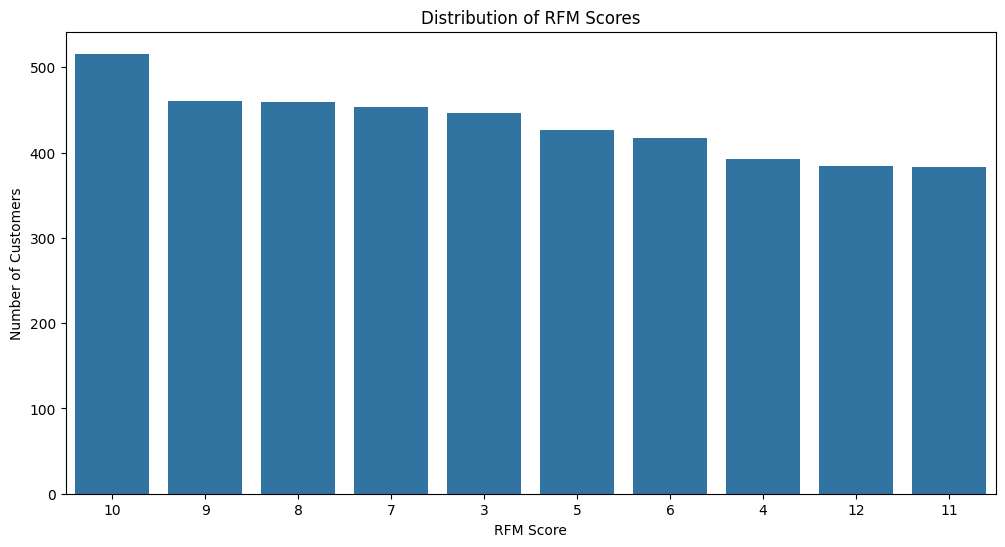

In [18]:
# Analyze RFM segments (example)
print("\nBest Customers (RFM Score 3):")
print(rfm[rfm['RFM_Score'] == 3].sort_values('MonetaryValue', ascending=False).head())

# Example of targetting strategies based on RFM
#print (rfm.groupby('RFM_Segment').size().sort_values(ascending=False)[:10])

# Visualizing Segment Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm, x='RFM_Score', order=rfm['RFM_Score'].value_counts().index)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.show()



Top 10 Best-Selling Products:
StockCode
23843     80995
23166     77916
84077     54415
22197     49183
85099B    46181
85123A    36782
84879     35362
21212     33693
23084     27202
22492     26076
Name: Quantity, dtype: int64


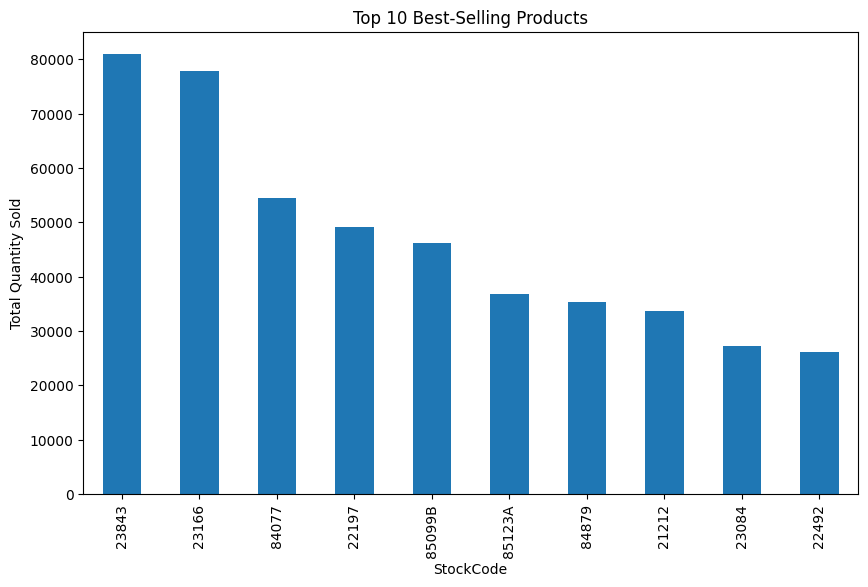

In [19]:
# Product Analysis (most popular products)

product_sales = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Best-Selling Products:")
print(product_sales)

plt.figure(figsize=(10, 6))
product_sales.plot(kind='bar')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('StockCode')
plt.ylabel('Total Quantity Sold')
plt.show()


In [24]:
# Cohort Analysis (More advanced - Demonstrates ability to analyze customer lifetime value)
# Create cohort month

df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Calculate the time offset for each invoice within its cohort.  This tells us how many months
# each customer has been retained.
df['CohortIndex'] = (df['InvoiceDate'].dt.to_period('M') - df['CohortMonth']).apply(lambda x: x.n)

# Group by cohort month and cohort index
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

In [25]:
# Pivot the table.  We will get a KeyError with the previous code if there are no customers that fall under a 
# specific period
cohort_counts = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID', fill_value=0)

print("\nCohort Counts:")
print(cohort_counts)


Cohort Counts:
CohortIndex     0      1      2      3      4      5      6      7      8   \
CohortMonth                                                                  
2010-12      885.0  324.0  286.0  340.0  321.0  352.0  321.0  309.0  313.0   
2011-01      417.0   92.0  111.0   96.0  134.0  120.0  103.0  101.0  125.0   
2011-02      380.0   71.0   71.0  108.0  103.0   94.0   96.0  106.0   94.0   
2011-03      452.0   68.0  114.0   90.0  101.0   76.0  121.0  104.0  126.0   
2011-04      300.0   64.0   61.0   63.0   59.0   68.0   65.0   78.0   22.0   
2011-05      284.0   54.0   49.0   49.0   59.0   66.0   75.0   27.0    0.0   
2011-06      242.0   42.0   38.0   64.0   56.0   81.0   23.0    0.0    0.0   
2011-07      188.0   34.0   39.0   42.0   51.0   21.0    0.0    0.0    0.0   
2011-08      169.0   35.0   42.0   41.0   21.0    0.0    0.0    0.0    0.0   
2011-09      299.0   70.0   90.0   34.0    0.0    0.0    0.0    0.0    0.0   
2011-10      358.0   86.0   41.0    0.0    0.0  

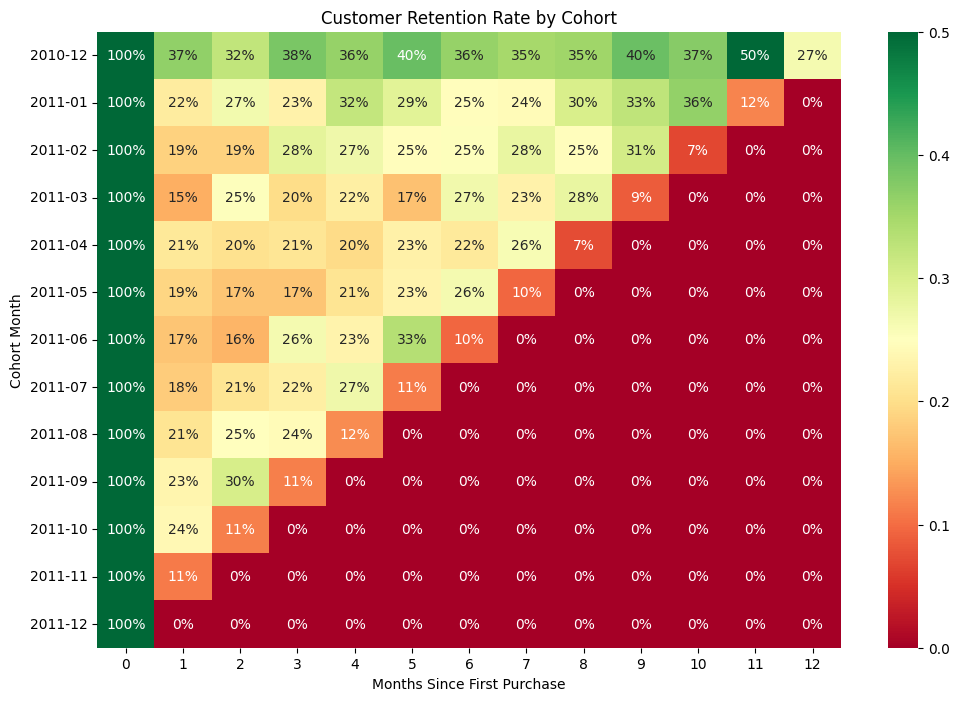

In [26]:
# Data Cleaning and Preprocessing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
df = df[df['Quantity'] > 0]

# Cohort Analysis
# 1. Create Cohort Month
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# 2. Create Cohort Index (Months since first purchase)
df['CohortIndex'] = (df['InvoiceDate'].dt.to_period('M') - df['CohortMonth']).apply(lambda x: x.n)

# 3. Create a table showing new customer counts for each cohort
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_counts = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID', fill_value=0)

# 4. Calculate Retention Rate
cohort_sizes = cohort_counts.iloc[:,0] # Size of each cohort in the first month
retention = cohort_counts.divide(cohort_sizes, axis=0) # divide by the cohort size to get the percentages

# 5. Plot the Heatmap
plt.figure(figsize=(12, 8))
plt.title('Customer Retention Rate by Cohort')

#Annotate heatmap with rounded retention rate
sns.heatmap(data = retention, annot = True, fmt = '.0%', cmap = 'RdYlGn', vmin = 0.0, vmax = 0.5)

plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')

plt.show()

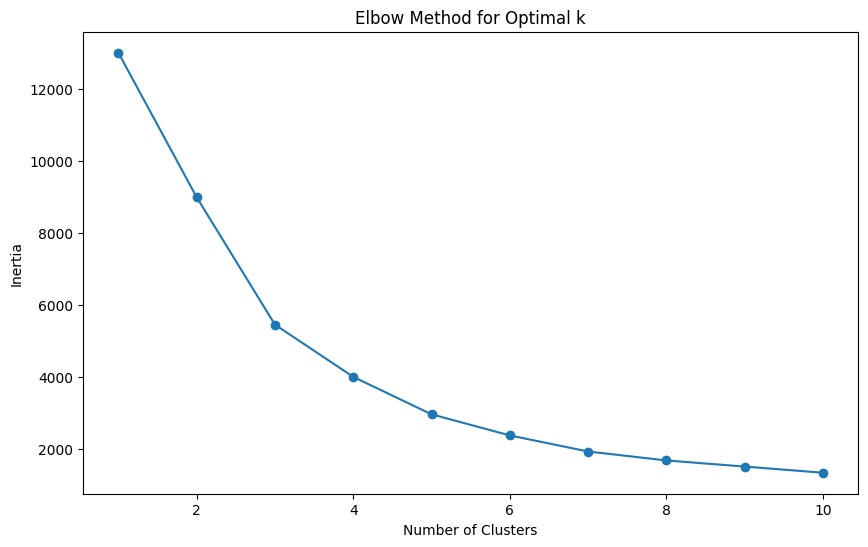

In [21]:
# Customer Segmentation (Beyond RFM)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the RFM values
rfm_scaled = StandardScaler().fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# Determine optimal number of clusters (Elbow Method)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0,n_init=10) # added n_init to suppress warning.
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()



In [22]:
# Choose a number of clusters based on the elbow plot (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10) # addded n_init
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("\nRFM Clusters:")
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean())


# Further Analysis (Requires more data and external data)

#  * Customer Churn Prediction (requires historical churn data)
#  * Product Recommendation System (requires more product data)
#  * Market Basket Analysis (requires transaction-level details)

# Store the RFM file in CSV so we don't have to continue to analyze
rfm.to_csv("rfm_segments.csv")


RFM Clusters:
            Recency    Frequency  MonetaryValue
Cluster                                        
0         40.344520   104.294951    2063.780669
1        246.308333    27.789815     637.318510
2          6.000000   847.142857  176606.164286
3          1.000000  5807.750000   70925.287500
